In [1]:
from pathlib import Path
from tqdm.autonotebook import tqdm
import json

import matplotlib.pyplot as plt
import cv2

from detectron2.structures.boxes import BoxMode

import sys
sys.path.append('../utils')

from train_eval import Evaluation

root_directory = Path("../data")
images_directory = root_directory / "images"
annots_directory =  root_directory / "annotations"
bbox_directory =  root_directory / "annotations-bbox"
masks_directory =  root_directory / "annotations-seg"

<ipython-input-1-d5fcb219b5e9>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Format Dataset to COCO Format

In [2]:
categories = {
     0: "bag",
     1: "belt",
     2: "boots",
     3: "footwear",
     4: "outer",
     5: "dress",
     6: "sunglasses",
     7: "pants",
     8: "top",
     9: "shorts",
    10: "skirt",
    11: "headwear",
    12: "scarf",
}

In [3]:
def get_files(fname, img_dir, annot_dir, masks_dir):
    files = {
        "file_name" : img_dir / (fname + ".jpg"),
        "file_annot" : annot_dir / (fname + ".txt"),
        "file_masks" : masks_dir / (fname + ".json")
    }
    return files

def get_labels(files, seg_id = 0, for_d2 = False):
    labels = {
        'annots': None,
        'masks': None,
    }
    
    with open(files["file_annot"]) as f:
        annot = f.readlines()
        annot_dicts = []
        
        for a in annot:
            a = a.split(" ")
            annot_d = {
                "category_id": int(a[0]),
                "x" : int(a[1]),
                "y" : int(a[2]),
                "width" : int(a[3]),
                "height": int(a[4]),
                "bbox" : [int(value) for value in a[1:]]
            }
            
            annot_dicts.append(annot_d)
        labels["annots"] = annot_dicts
        
    with open(files["file_masks"]) as f:
        masks = json.load(f)
        
        for idx, annot_d in enumerate(masks):
            
            bbox = annot_d.pop("bounding-box")
            if for_d2:  annot_d["bbox_mode"] = BoxMode.XYWH_ABS
            seg_id += 1
            annot_d["id"] = seg_id
            annot_d["area"] = 0
            
            try:
                annot_d["bbox"] = labels["annots"][idx]["bbox"]
                annot_d["category_id"] = int(labels["annots"][idx]["category_id"])
                
            except Exception:
                annot_d["bbox"] = [int(val) for val in bbox.values()]
                annot_d["category_id"] = int(annot_d["category_id"])
                
            labels["masks"] = masks
    return labels, seg_id

def get_cloths_dict_coco():
    base_dir = Path("../data")
    
    if (base_dir / "annotations" /"modanet_coco.json").exists():
        with open(base_dir /  "annotations" / "modanet_coco.json") as f:
            return json.load(f)
    
    img_dir = Path(base_dir) / "images"
    annot_dir = Path(base_dir) / "annotations-bbox"
    masks_dir = Path(base_dir) / "annotations-seg"

    dataset_dict = {
        'images' : [],
        'annotations': [],
        'categories': []
    }
    
    files = img_dir.iterdir()
    seg_id = 0
    for idx, img_f in tqdm(enumerate(files), total = len(files)):
        files_d = get_files(img_f.stem, img_dir, annot_dir, masks_dir)
        height, width = cv2.imread(str(files_d["file_name"])).shape[:2]

        record = {}
        record["file_name"] = str(files_d["file_name"].parts[-1])
        record["id"] = int(img_f.stem)
        record["height"] = int(height)
        record["width"] = int(width)
        
        dataset_dict["images"].append(record)
        
        labels, seg_id = get_labels(files_d, seg_id)
        
        img_annotations = []
        for simple_annot, full_annot in zip(labels["annots"], labels["masks"]):
            obj = full_annot
            obj["image_id"] = record["id"]
            img_annotations.append(obj)
            
        dataset_dict["annotations"] += img_annotations
        
        
    for idx, cat in categories.items():
        obj = {
            "supercategory": cat,
            "id" : idx,
            "name": cat
        }
        
        dataset_dict["categories"].append(obj)
    
    # fill extra entries of coco format
    dataset_dict["info"] = {
      "contributor": "",
      "date_created": "",
      "description": "",
      "url": "",
      "version": "",
      "year": ""
    }
    
    dataset_dict["licences"] = [
      {
        "id": "",
        "name": "",
        "url": ""
      }
]
    return dataset_dict

def get_cloths_dict_d2():
    base_dir = Path("../data")
    
    if (base_dir / "modanet_coco_d2.json").exists():
        with open(base_dir / "modanet_coco_d2.json") as f:
            return json.load(f)
    
    
    img_dir = Path(base_dir) / "images"
    annot_dir = Path(base_dir) / "annotations-bbox"
    masks_dir = Path(base_dir) / "annotations-seg"

    dataset_dicts = []
    files = img_dir.iterdir()
    seg_id = 0
    for idx, img_f in tqdm(enumerate(files)):
        files = get_files(img_f.stem, img_dir, annot_dir, masks_dir)
        height, width = cv2.imread(str(files["file_name"])).shape[:2]

        record = {}
        record["file_name"] = str(files["file_name"])
        record["image_id"] = int(img_f.stem)
        record["height"] = int(height)
        record["width"] = int(width)
                
        labels, seg_id = get_labels(files, seg_id, for_d2 = True)
        
        annots = []
        for simple_annot, full_annot in zip(labels["annots"], labels["masks"]):
            obj = full_annot
            annots.append(obj)
            
        record["annotations"] = annots
        
        dataset_dicts.append(record)
        
    return dataset_dicts

In [4]:
modanet_dict_coco = get_cloths_dict_coco()
modanet_dicts_d2 = get_cloths_dict_d2()

# with open("../data/annotations/modanet_coco.json", "w") as f:
#     json.dump(modanet_dict_coco, fp=f)
    
# with open("../data/modanet_coco_d2.json", "w") as f:
#     json.dump(modanet_dicts_d2, fp=f)

## Explore Dataset

In [5]:
import os
import glob
import random
import remo

remo.connect()
remo.set_viewer('jupyter')
    
# modanet_segmentation_dataset = remo.create_dataset(
#     name = 'modanet_segmentation_full', 
#     local_files = [annots_directory, images_directory], 
#     annotation_task='Instance Segmentation', 
#     wait_for_complete=True
# )

modanet_segmentation_dataset = remo.Dataset(id = 1, name = "modanet_segmentation_full", quantity=10)

In [6]:
modanet_segmentation_dataset.view()

Open http://localhost:8123/datasets/1


In [7]:
modanet_segmentation_dataset.get_annotation_statistics(2)

[{'AnnotationSet ID': 2,
  'AnnotationSet name': 'Instance Segmentation',
  'n_images': 52254,
  'n_classes': 13,
  'n_objects': 355925,
  'top_3_classes': [{'name': 'Footwear', 'count': 87033},
   {'name': 'Top', 'count': 56058},
   {'name': 'Outer', 'count': 51286}],
  'creation_date': None,
  'last_modified_date': '2021-08-11T18:32:11.987561Z'}]

In [8]:
# Create train/test

im_list = [i for i in glob.glob(str(images_directory) + '/*', recursive=True)]
im_list = random.sample(im_list, len(im_list))

train_idx = round(len(im_list) * 0.8)
test_idx  = train_idx + round(len(im_list) * 0.2)

tags_dict =  {'train' : im_list[0:train_idx], 
              'test' : im_list[train_idx:test_idx]}

path_to_annotations = '../data/annotations/'

# train_test_split_file_path = os.path.join(annots_directory, 'images_tags.csv') 
# remo.generate_image_tags(tags_dictionary  = tags_dict, 
#                          output_file_path = train_test_split_file_path, 
#                          append_path = False)


path_to_train = annots_directory / 'modanet_instance_segmentation_train.json'
path_to_test = annots_directory / 'modanet_instance_segmentation_test.json'

# if not path_to_train.exists():
#     modanet_segmentation_dataset.export_annotations_to_file(
#         str(path_to_train),
#         annotation_format='coco',
#         filter_by_tags=['train'],
#         export_tags=False,
#         append_path=False)
    
# if not path_to_test.exists():
#     modanet_segmentation_dataset.export_annotations_to_file(
#         str(path_to_test),
#         annotation_format='coco',
#         filter_by_tags=['test'],
#         export_tags=False,
#         append_path=False)

In [9]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

register_coco_instances('modanet_instance_segmentation_train', {}, path_to_train, images_directory)
register_coco_instances('modanet_instance_segmentation_test', {}, path_to_test, images_directory)

MetadataCatalog.get('modanet_instance_segmentation_train').set(
    thing_classes=['bag', 'dress', 'footwear', 'skirt', 'top', 'sunglasses', \
                   'headwear', 'shorts', 'pants', 'belt', 'outer', 'scarf', 'boots']
)
train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')

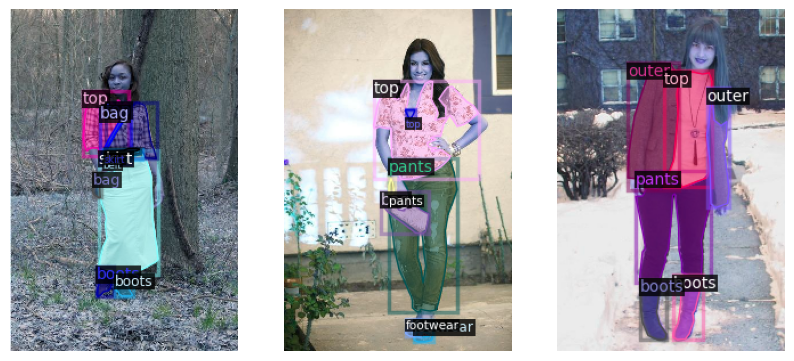

In [10]:
from detectron2.data.datasets import load_coco_json
dataset_dicts = load_coco_json("../data/annotations/modanet_instance_segmentation_train.json", "../data/images/")

Evaluation._show_n(dataset_dicts, train_metadata, predictions=False)

### Possible Issues w/ Remo

In [11]:
dataset_dicts = load_coco_json("../data/annotations/modanet_instance_segmentation_train.json", "../data/images/")
{annos["category_id"]  for d in dataset_dicts for annos in d["annotations"]}

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [12]:
with open("../data/annotations/modanet_instance_segmentation_train.json") as f:
    dset_dict = json.load(f)
dset_dict['categories']

[{'id': 0, 'name': 'bag', 'supercategory': 'bag'},
 {'id': 1, 'name': 'dress', 'supercategory': 'dress'},
 {'id': 2, 'name': 'footwear', 'supercategory': 'footwear'},
 {'id': 3, 'name': 'skirt', 'supercategory': 'skirt'},
 {'id': 4, 'name': 'top', 'supercategory': 'top'},
 {'id': 5, 'name': 'sunglasses', 'supercategory': 'sunglasses'},
 {'id': 6, 'name': 'headwear', 'supercategory': 'headwear'},
 {'id': 7, 'name': 'shorts', 'supercategory': 'shorts'},
 {'id': 8, 'name': 'pants', 'supercategory': 'pants'},
 {'id': 9, 'name': 'belt', 'supercategory': 'belt'},
 {'id': 10, 'name': 'outer', 'supercategory': 'outer'},
 {'id': 11, 'name': 'scarf', 'supercategory': 'scarf'},
 {'id': 12, 'name': 'boots', 'supercategory': 'boots'}]

In [13]:
with open("../data/annotations/modanet_instance_segmentation_train.json") as f:
    dset_dict = json.load(f)
    cleaned_annos_ids = {annos["category_id"] : annos["category_id"]-91 for annos in dset_dict["annotations"]}
    cleaned_cat_ids = {cat["id"] : cat["id"]-91 for cat in dset_dict["categories"]}

def clean_cat_ids(path):
    with open(path, "r") as f:
        dataset_dict = json.load(f)
        
        cleaned = 0
#         for idx, annos in enumerate(dataset_dict["annotations"]):
#             try:
#                 annos["category_id"] = cleaned_annos_ids[annos["category_id"]]
#                 cleaned += 1
#             except KeyError:
#                 pass
            
#             dataset_dict["annotations"][idx] = annos

        print(f"Cleaned {cleaned} annotations...")  
        
        cleaned = 0
        for idx, cats in enumerate(dataset_dict["categories"]):
            try:
                cats["id"] = cleaned_cat_ids[cats["id"]]
                cleaned += 1
            except KeyError:
                print(cleaned_ids[cats["id"]])
                pass
            
            dataset_dict["categories"][idx] = cats
            
        print(f"Cleaned {cleaned} categories...")  

    with open(path, "w") as f:
        json.dump(dataset_dict, f)
        
# clean_cat_ids(path_to_train)
# clean_cat_ids(path_to_test)

## Test a Model

In [14]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo

import random
random.seed(600)

### Training

In [15]:
from detectron2.config import LazyCall as L
from detectron2.layers import ShapeSpec
from detectron2.modeling.meta_arch import GeneralizedRCNN
from detectron2.modeling.anchor_generator import DefaultAnchorGenerator
from detectron2.modeling.backbone.fpn import LastLevelMaxPool
from detectron2.modeling.backbone import BasicStem, FPN, ResNet
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.matcher import Matcher
from detectron2.modeling.poolers import ROIPooler
from detectron2.modeling.proposal_generator import RPN, StandardRPNHead
from detectron2.modeling.roi_heads import (
    StandardROIHeads,
    FastRCNNOutputLayers,
    MaskRCNNConvUpsampleHead,
    FastRCNNConvFCHead,
)

model = L(GeneralizedRCNN)(
    backbone=L(FPN)(
        bottom_up=L(ResNet)(
            stem=L(BasicStem)(in_channels=3, out_channels=64, norm="FrozenBN"),
            stages=L(ResNet.make_default_stages)(
                depth=50,
                stride_in_1x1=True,
                norm="FrozenBN",
            ),
            out_features=["res2", "res3", "res4", "res5"],
        ),
        in_features="${.bottom_up.out_features}",
        out_channels=256,
        top_block=L(LastLevelMaxPool)(),
    ),
    proposal_generator=L(RPN)(
        in_features=["p2", "p3", "p4", "p5", "p6"],
        head=L(StandardRPNHead)(in_channels=256, num_anchors=3),
        anchor_generator=L(DefaultAnchorGenerator)(
            sizes=[[32], [64], [128], [256], [512]],
            aspect_ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64],
            offset=0.0,
        ),
        anchor_matcher=L(Matcher)(
            thresholds=[0.3, 0.7], labels=[0, -1, 1], allow_low_quality_matches=True
        ),
        box2box_transform=L(Box2BoxTransform)(weights=[1.0, 1.0, 1.0, 1.0]),
        batch_size_per_image=256,
        positive_fraction=0.5,
        pre_nms_topk=(2000, 1000),
        post_nms_topk=(1000, 1000),
        nms_thresh=0.7,
    ),
    roi_heads=L(StandardROIHeads)(
        num_classes=80,
        batch_size_per_image=512,
        positive_fraction=0.25,
        proposal_matcher=L(Matcher)(
            thresholds=[0.5], labels=[0, 1], allow_low_quality_matches=False
        ),
        box_in_features=["p2", "p3", "p4", "p5"],
        box_pooler=L(ROIPooler)(
            output_size=7,
            scales=(1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32),
            sampling_ratio=0,
            pooler_type="ROIAlignV2",
        ),
        box_head=L(FastRCNNConvFCHead)(
            input_shape=ShapeSpec(channels=256, height=7, width=7),
            conv_dims=[],
            fc_dims=[1024, 1024],
        ),
        box_predictor=L(FastRCNNOutputLayers)(
            input_shape=ShapeSpec(channels=1024),
            test_score_thresh=0.05,
            box2box_transform=L(Box2BoxTransform)(weights=(10, 10, 5, 5)),
            num_classes="${..num_classes}",
        ),
        mask_in_features=["p2", "p3", "p4", "p5"],
        mask_pooler=L(ROIPooler)(
            output_size=14,
            scales=(1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32),
            sampling_ratio=0,
            pooler_type="ROIAlignV2",
        ),
        mask_head=L(MaskRCNNConvUpsampleHead)(
            input_shape=ShapeSpec(channels=256, width=14, height=14),
            num_classes="${..num_classes}",
            conv_dims=[256, 256, 256, 256, 256],
        ),
    ),
    pixel_mean=[103.530, 116.280, 123.675],
    pixel_std=[1.0, 1.0, 1.0],
    input_format="BGR",
)

In [16]:
import logging

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detectron2.engine import (
    AMPTrainer,
    SimpleTrainer,
    default_setup,
    default_argument_parser,
    default_writers,
    hooks,
    launch
)
from detectron2.engine.defaults import create_ddp_model
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm

In [17]:
def create_lazy_cfg(lazy_path, max_iter = 100):
    print(f"Creating {lazy_path}...\n")
    cfg = LazyConfig.load(model_zoo.get_config_file(lazy_path))
    default_setup(cfg, [])
    
    model = cfg.model
    model.backbone.bottom_up.stem.norm = \
    model.backbone.bottom_up.stages.norm = \
    model.backbone.norm = "FrozenBN"
    cfg.model = model
    
    cfg.train.amp.enabled = True
    cfg.train.output_dir = '../logs/exploration_test'
    cfg.train.max_iter = max_iter
    cfg.model.roi_heads.num_classes = 13
    cfg.dataloader.train.dataset.names = 'modanet_instance_segmentation_train'
    cfg.dataloader.test.dataset.names = 'modanet_instance_segmentation_test'
    
    return cfg

def do_train(cfg):
    model = instantiate(cfg.model)
    logger = logging.getLogger("detectron2")
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)

    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)

    train_loader = instantiate(cfg.dataloader.train)

#     model = create_ddp_model(model, **cfg.train.ddp)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)
    checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        optimizer=optim,
        trainer=trainer,
    )
    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
            if comm.is_main_process()
            else None,
            hooks.EvalHook(cfg.train.eval_period, lambda: do_test(cfg, model)),
            hooks.PeriodicWriter(
                default_writers(cfg.train.output_dir, cfg.train.max_iter),
                period=cfg.train.log_period,
            )
            if comm.is_main_process()
            else None,
        ]
    )

    checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=False)
    start_iter = 0
    trainer.train(start_iter, cfg.train.max_iter)

In [18]:
def run_lazy(lazy_path):
    cfg = create_lazy_cfg(lazy_path)
    do_train(cfg)
    
new_model_lazy_path = 'new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py'
run_lazy(new_model_lazy_path)

Creating new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py...

[08/11 22:59:04 detectron2]: Rank of current process: 0. World size: 1
[08/11 22:59:04 detectron2]: Rank of current process: 0. World size: 1
[08/11 22:59:04 detectron2]: Environment info:
----------------------  ---------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.11 (default, Aug  3 2021, 15:09:35) [GCC 7.5.0]
numpy                   1.20.3
detectron2              0.5 @/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0 @/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3070 (arch=8.6)
CUDA_HOME               /opt/cuda
Pillow 

[08/11 22:59:04 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
    )
    (fpn_output4): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (

[08/11 22:59:09 d2.data.datasets.coco]: Loading ../data/annotations/modanet_instance_segmentation_train.json takes 2.71 seconds.
[08/11 22:59:09 d2.data.datasets.coco]: Loading ../data/annotations/modanet_instance_segmentation_train.json takes 2.71 seconds.
WARNING [08/11 22:59:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [08/11 22:59:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/11 22:59:09 d2.data.datasets.coco]: Loaded 41803 images in COCO format from ../data/annotations/modanet_instance_segmentation_train.json
[08/11 22:59:09 d2.data.datasets.coco]: Loaded 41803 images in COCO format from ../data/annotations/modanet_instance_segmentation_train.json
[08/11 22:59:12 d2.data.build]: Removed 0 images with no usable annotations. 41803 images left.
[08/11 22:59:12 d2.data.build]: Removed 0 images with no usable annotations. 41803 image

/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


ERROR [08/11 22:59:15 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 395, in run_step
    loss_dict = self.model(data)
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/modeling/meta_arch/rcnn.py", line 154, in forward
    features = self.backbone(images.tensor)
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/modeling/backbone/fpn.py", line 126, in

RuntimeError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 7.79 GiB total capacity; 5.30 GiB already allocated; 154.38 MiB free; 5.31 GiB reserved in total by PyTorch)

In [ ]:
from detectron2.config import get_cfg

model_yaml_path = 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'
# model_weights_path = 'detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

# cfg = LazyConfig.load()
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_yaml_path))
cfg.OUTPUT_DIR = '../logs/exploration_test'
cfg.DATASETS.TRAIN = ('modanet_instance_segmentation_train',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01

cfg.SOLVER.NUM_GPUS = 1
single_iteration = cfg.SOLVER.NUM_GPUS * cfg.SOLVER.IMS_PER_BATCH
iterations_for_one_epoch = len(dataset_dicts) / single_iteration
cfg.SOLVER.MAX_ITER = iterations_for_one_epoch * 2 # -> 2 epochs?   

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml_path)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

In [ ]:
# from detectron2.engine import DefaultTrainer

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

### Evaluate

In [ ]:
eval_tools = Evaluation(cfg, "modanet_instance_segmentation_test")

In [ ]:
# eval_tools.run_coco_eval()

### Visualizations

In [ ]:
# from detectron2.engine import DefaultPredictor

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4 # original 0.5
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set the testing threshold for this model
# cfg.DATASETS.TEST = ('modanet_instance_segmentation_test', )
# predictor = DefaultPredictor(cfg)

train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')
test_dataset_dicts = DatasetCatalog.get('modanet_instance_segmentation_test')

In [ ]:
eval_tools.show_n(dataset_dicts=test_dataset_dicts, metadata=train_metadata, predictions = True)

In [ ]:
mapping = {k: v for k, v in enumerate(train_metadata.thing_classes)}
mapping

In [ ]:
test_annots = eval_tools.createAnnots(test_dataset_dicts, mapping = mapping, sample_ratio=2)

In [ ]:
# model_predictions = modanet_segmentation_dataset.create_annotation_set(
#     annotation_task = 'Instance Segmentation', name = 'exploration_preds_sampleratio2')

# modanet_segmentation_dataset.add_annotations(test_annots, annotation_set_id=model_predictions.id)

In [ ]:
modanet_segmentation_dataset.view()